- preprocessing
- oov embeddings init
- model
- extra features
- translate and back
- ideas from third place :https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644

In [0]:
import pandas as pd
import torchtext
import random
from torchtext.data import TabularDataset
import numpy as np
import os
from torchtext import data
import torch.nn as nn
import torch
import torch.optim as optim
import time
from sklearn.metrics import roc_auc_score,accuracy_score
import spacy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
os.environ['KAGGLE_USERNAME'] = "yonigottesman" # username from the json file 
os.environ['KAGGLE_KEY'] = "4b38ea3d9a7d2a9ee47010dc9650dd7d" # key from the json file 

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip '*.csv.zip'

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 46.1MB/s]
 94% 22.0M/23.4M [00:00<00:00, 76.1MB/s]
100% 23.4M/23.4M [00:00<00:00, 115MB/s] 
 84% 22.0M/26.3M [00:01<00:00, 5.50MB/s]
100% 26.3M/26.3M [00:01<00:00, 18.2MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 47.9MB/s]
Archive:  test.csv.zip
  inflating: test.csv                

Archive:  test_labels.csv.zip
  inflating: test_labels.csv         

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

4 archives were successfully processed.


# Preprocessing

In [0]:
# ideas taken from here https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2
contraction_mapping = {'fggt':'faggot', 'cocksucker':'cock sucker','bastered':'bastard',"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': '','→':' ','\t':' ', '\n':' '} 
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

nlp = spacy.load("en")
def tokenizer_with_preprocess(text):
  text = clean_contractions(text, contraction_mapping)
  text = clean_special_chars(text, punct,punct_mapping)
  return [token.text for token in nlp.tokenizer(text) if not token.is_space]

In [0]:
df_train = pd.read_csv('/content/train.csv')
df_train['comment_text'] = df_train['comment_text'].apply(lambda t: ' '.join(tokenizer_with_preprocess(t)))

df_test = pd.read_csv('/content/test.csv')
df_test['comment_text'] = df_test['comment_text'].apply(lambda t: ' '.join(tokenizer_with_preprocess(t)))

In [0]:
# add extra features: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644
def unique_words_rate(text):
  token_text = text.split()
  if len(text) == 0:
    return 0
  return len(set(w for w in token_text))/len(token_text)

# count total caps in text. TODO yonigo: try whole word caps rate
def all_caps_rate(text):
  if len(text) == 0:
    return 0
  return sum(1 for c in text if c.isupper())/len(text)

def add_extra_features(df):
  df['unique_words_rate'] = df['comment_text'].apply(unique_words_rate)
  df['all_caps_rate'] = df['comment_text'].apply(all_caps_rate)


add_extra_features(df_train)
add_extra_features(df_test)

df_train.to_csv('/content/train_extra.csv', index=False)
df_test.to_csv('/content/test_extra.csv', index=False)

In [0]:
df = pd.read_csv('/content/train_extra.csv')

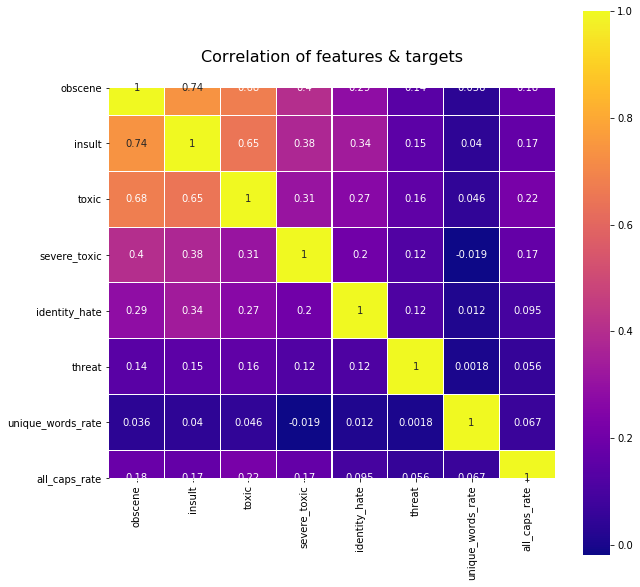

In [33]:
colormap = plt.cm.plasma
plt.figure(figsize=(10,10))
plt.title('Correlation of features & targets',y=1.05,size=16)
sns.heatmap(df[['obscene','insult','toxic','severe_toxic','identity_hate','threat','unique_words_rate','all_caps_rate']].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# hyperparams
TEXT_LENGTH = 100
EMBEDDING_SIZE = 300
BATCH_SIZE = 64
VOCAB_SIZE=20000

In [0]:
TEXT = data.Field(lower=True, batch_first=True,fix_length=TEXT_LENGTH, preprocessing=None)
LABEL = data.Field(sequential=False,is_target=True, use_vocab=False, pad_token=None, unk_token=None)
EXTRA = data.Field(sequential=False, dtype=torch.float, batch_first=True, use_vocab=False, preprocessing= lambda x: float(x))
datafields = [('id', None),
              ('comment_text', TEXT), 
              ("toxic", LABEL), 
              ("severe_toxic", LABEL),
              ('obscene', LABEL), 
              ('threat', LABEL),
              ('insult', LABEL),
              ('identity_hate', LABEL),
              ('unique_words_rate', EXTRA),
              ('all_caps_rate', EXTRA)]


alldata = TabularDataset(
    path='/content/train_extra.csv',
    format='csv',
    skip_header=True,
    fields=datafields,)
random.seed(17)
train,dev = alldata.split(split_ratio=0.9, random_state=random.getstate())

In [0]:
#vars(train[0])

In [203]:
glove_vectors = torchtext.vocab.GloVe(name='6B', dim=EMBEDDING_SIZE,cache='/content/drive/My Drive/pretrained_vectors')
glove_mean, glove_std = glove_vectors.vectors.mean(), glove_vectors.vectors.std()

100%|█████████▉| 399895/400000 [00:47<00:00, 8654.03it/s]

In [204]:
TEXT.build_vocab(train, vectors=glove_vectors, max_size=20000, min_freq=5)

100%|█████████▉| 399895/400000 [01:00<00:00, 8654.03it/s]

In [0]:
# init oov embeddings with same istribution as glove
# skip <unk> and padding
for i in range(2, len(TEXT.vocab.vectors)):
        if len(TEXT.vocab.vectors[i, :].nonzero()) == 0:
          nn.init.normal_(TEXT.vocab.vectors[i], mean=glove_mean, std=glove_std)

In [0]:
random.seed(1234)
train_iterator, valid_iterator = data.BucketIterator.splits((train, dev),
                                                            batch_size=BATCH_SIZE,
                                                            device=device,
                                                            shuffle=True,
                                                            sort_key=lambda x: len(x.comment_text))

# Explore what preprocessing to do

In [208]:
total_words = len(TEXT.vocab.stoi)
words_in_embeddings = 0
total_in_embeddings = 0
total_count=0
oov = {}
for word in TEXT.vocab.stoi:
  if word in glove_vectors.stoi:
    words_in_embeddings+=1
    total_in_embeddings+=TEXT.vocab.freqs[word]
  else:
    oov[word] = TEXT.vocab.freqs[word]

  total_count+=TEXT.vocab.freqs[word]
print('Found embeddings for {:.2%} of vocab'.format( words_in_embeddings/ total_words))
print('Found embeddings for  {:.2%} of all text'.format(total_in_embeddings / total_count))

Found embeddings for 94.99% of vocab
Found embeddings for  99.47% of all text


In [0]:
sorted(oov.items(), key = lambda k: k[1],reverse=True)[:50]
# TODO yonigo: remove some more special chars. maybe split word that contain fuck? replace fggt with faggot?
#TEXT.vocab.stoi['faggot']
#glove_vectors.stoi['fggt']

# Model and training

In [0]:
class NNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx, embeddings, text_length, lstm_hidden_size):
        super().__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=pad_idx)
        # spacial dropout according to this post: https://discuss.pytorch.org/t/spatial-dropout-in-pytorch/21400/4
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=lstm_hidden_size, 
                            num_layers=1, batch_first=True, bidirectional=True)
        
        self.gru = nn.GRU(lstm_hidden_size*2, lstm_hidden_size, bidirectional=True, batch_first=True)

        self.max_pool = nn.MaxPool2d((text_length,1))
        self.avg_pool = nn.AvgPool2d((text_length,1))
        self.fc1 = nn.Linear(lstm_hidden_size*6+2, output_dim)

    def forward(self, text, extra_features):
        embeddings = self.embeddings(text)
        embeddings = embeddings.permute(0, 2, 1)   # convert to [batch, channels, time]
        embeddings = self.embedding_dropout(embeddings)
        embeddings = embeddings.permute(0, 2, 1)   # back to [batch, time, channels]


        output_lstm,_ = self.lstm(embeddings)
        output_gru, h_n_gru = self.gru(output_lstm)
        h_n_gru = h_n_gru.view(-1, 2*self.lstm_hidden_size)
        a3_max = self.max_pool(output_gru).squeeze(1)
        a3_avg = self.avg_pool(output_gru).squeeze(1)
        a3_cat = torch.cat([a3_max,a3_avg,h_n_gru,extra_features],dim=1)
        a4 = self.fc1(a3_cat)
        return a4

In [199]:
# playground
#next(iter(train_iterator)).comment_text.shape
#batch = next(iter(train_iterator))
#model = NNet(len(TEXT.vocab), EMBEDDING_SIZE, 6, TEXT.vocab.stoi[TEXT.pad_token], TEXT.vocab.vectors,TEXT_LENGTH, 100).to(device)
#embeddings = model.embeddings(batch.comment_text)
#output,_ = model.lstm(embeddings)
#output, h_n = model.gru(output)
#h_n.shape
#h_n.view(-1, 2*100).shape
#batch.unique_words_rate.unsqueeze(1)
#batch.all_caps_rate.unsqueeze(1)
#extra = torch.cat([batch.unique_words_rate.unsqueeze(1),batch.all_caps_rate.unsqueeze(1) ],dim=1)
#model(batch.comment_text, extra)
#lstmout = model.lstm(embeddings)[0]
#model.max_pool(lstmout).shape

torch.Size([64, 100])

In [207]:
OUTPUT_DIM = 6
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model = NNet(len(TEXT.vocab), EMBEDDING_SIZE, OUTPUT_DIM, PAD_IDX, TEXT.vocab.vectors,TEXT_LENGTH, 50).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,188,818 trainable parameters


In [0]:
def fit_epoch(iterator, model, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    model.train()
    all_y = []
    all_y_hat = []
    for batch in iterator:
        optimizer.zero_grad()
        y = torch.stack([batch.toxic,
                         batch.severe_toxic,
                         batch.obscene,
                         batch.threat,
                         batch.insult,
                         batch.identity_hate],dim=1).float().to(device)
        extra_features = torch.cat([batch.unique_words_rate.unsqueeze(1),batch.all_caps_rate.unsqueeze(1) ],dim=1)
        y_hat = model(batch.comment_text.to(device), extra_features)
        loss = criterion(y_hat, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        all_y.append(y)
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    roc = roc_auc_score(y.cpu(),y_hat.sigmoid().detach().cpu())
    return train_loss / len(iterator.dataset), roc

def test_epoch(iterator, model, criterion):
    train_loss = 0
    train_acc = 0
    model.eval()
    all_y = []
    all_y_hat = []
    for batch in iterator:
        y = torch.stack([batch.toxic,
                         batch.severe_toxic,
                         batch.obscene,
                         batch.threat,
                         batch.insult,
                         batch.identity_hate],dim=1).float().to(device)
        extra_features = torch.cat([batch.unique_words_rate.unsqueeze(1),batch.all_caps_rate.unsqueeze(1) ],dim=1)                         
        with torch.no_grad():
            y_hat = model(batch.comment_text.to(device), extra_features)
        loss = criterion(y_hat, y)
        train_loss += loss.item()
        all_y.append(y)
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    roc = roc_auc_score(y.cpu(),y_hat.sigmoid().detach().cpu())
    return train_loss / len(iterator.dataset), roc

In [0]:
def train_n_epochs(n, lr, wd):

    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for epoch in range(n):
        start_time = time.time()
        train_loss, train_roc = fit_epoch(train_iterator, model, optimizer, criterion)
        valid_loss, valid_roc = test_epoch(valid_iterator, model, criterion)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\troc: {train_roc :.6f} (train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\troc: {valid_roc:.6f} (valid)') 

In [209]:
train_n_epochs(5,0.001,0.00001)

Epoch: 1  | time in 1 minutes, 38 seconds
	Loss: 0.0010(train)	|	roc: 0.955525 (train)
	Loss: 0.0008(valid)	|	roc: 0.973496 (valid)
Epoch: 2  | time in 1 minutes, 38 seconds
	Loss: 0.0007(train)	|	roc: 0.977327 (train)
	Loss: 0.0007(valid)	|	roc: 0.980147 (valid)
Epoch: 3  | time in 1 minutes, 37 seconds
	Loss: 0.0007(train)	|	roc: 0.982683 (train)
	Loss: 0.0007(valid)	|	roc: 0.984237 (valid)
Epoch: 4  | time in 1 minutes, 38 seconds
	Loss: 0.0006(train)	|	roc: 0.985655 (train)
	Loss: 0.0007(valid)	|	roc: 0.984906 (valid)
Epoch: 5  | time in 1 minutes, 37 seconds
	Loss: 0.0006(train)	|	roc: 0.987268 (train)
	Loss: 0.0007(valid)	|	roc: 0.984995 (valid)


In [210]:
train_n_epochs(5,0.0001,0.00001)

Epoch: 1  | time in 1 minutes, 37 seconds
	Loss: 0.0007(train)	|	roc: 0.985994 (train)
	Loss: 0.0007(valid)	|	roc: 0.985137 (valid)
Epoch: 2  | time in 1 minutes, 37 seconds
	Loss: 0.0006(train)	|	roc: 0.988232 (train)
	Loss: 0.0007(valid)	|	roc: 0.985561 (valid)
Epoch: 3  | time in 1 minutes, 37 seconds
	Loss: 0.0006(train)	|	roc: 0.989270 (train)
	Loss: 0.0007(valid)	|	roc: 0.985488 (valid)


KeyboardInterrupt: ignored

# Prepare and send testset

In [0]:
dataFields = [("id", None), ("comment_text", TEXT), ('unique_words_rate', EXTRA), ('all_caps_rate', EXTRA)]
testDataset= data.TabularDataset(path='/content/test_extra.csv', 
                                            format='csv',
                                            fields=dataFields, 
                                            skip_header=True)

test_iter = data.Iterator(testDataset,
                          batch_size=BATCH_SIZE,
                          device=device,
                          sort=False,
                          sort_within_batch=False,
                          repeat=False,
                          shuffle=False)

model.eval()
all_predictions = []
for batch in test_iter:
    with torch.no_grad():
        extra_features = torch.cat([batch.unique_words_rate.unsqueeze(1),batch.all_caps_rate.unsqueeze(1) ],dim=1)
        y_hat = model(batch.comment_text, extra_features)
    pred = torch.sigmoid(y_hat)
    all_predictions.append(pred)
predictions = torch.cat(all_predictions)

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_df = pd.read_csv('/content/sample_submission.csv')
sample_df[list_classes] = predictions.cpu()
sample_df.to_csv('submission.csv', index=False)

In [213]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f '/content/submission.csv' -m "bidirect lstm avg+max+preprocess+embeddings_init+extra_featurs+gru+300dim submition"

100% 21.4M/21.4M [00:08<00:00, 2.54MB/s]
Successfully submitted to Toxic Comment Classification Challenge

In [0]:
#best  0.984101